In [1]:
import cv2
import numpy as np 
import os 
import pandas as pd
import torch

from importlib import import_module
from tqdm import tqdm 

from skp.toolbox.functions import load_model_from_config

In [2]:
def dice_score(x, y):
    return 2 * (x * y).sum() / (x.sum() + y.sum())

In [3]:
def convert_class_logits_to_class_labels(logits):
    # logits.shape = (n, num_classes, h, w)
    logits = logits.sigmoid()
    logits = torch.cat([1 - logits.amax(1, keepdim=True), logits], dim=1)
    return logits.argmax(1)

In [4]:
cfg_name = "totalclassifier.cfg_seg_effnet_adapt3d"
cfg = import_module(f"skp.configs.{cfg_name}").cfg

model = load_model_from_config(cfg, weights_path=os.path.join(cfg.save_dir, cfg_name, "b05eb12a/fold0/checkpoints/last.ckpt"), device="cuda:0", eval_mode=True)
# model = load_model_from_config(cfg, weights_path=os.path.join(cfg.save_dir, cfg_name, "6a44ea20/fold0/checkpoints/last.ckpt"), device="cuda:0", eval_mode=True)
# model = load_model_from_config(cfg, weights_path="/home/ian/projects/SKP/experiments/totalclassifier/totalclassifier.cfg_seg_cls_mpr_224/95af2b1a/fold0/checkpoints/last.ckpt", device="cuda:0", eval_mode=True)

/home/ian/miniconda3/envs/skp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ian/miniconda3/envs/skp/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Enabling gradient checkpointing ...
Loading weights from /home/ian/projects/SKP/experiments/totalclassifier/totalclassifier.cfg_seg_effnet_adapt3d/b05eb12a/fold0/checkpoints/last.ckpt ...


In [30]:
df = pd.read_csv(cfg.annotations_file)
val_df = df.loc[df.fold == 0]
val_dfs = [_df for _, _df in val_df.groupby("sid_plane") if "axial" in _]
print(len(val_dfs))

245


In [31]:
dice_scores = {idx: [] for idx in range(1, 118)}

In [32]:
for tmp_df in tqdm(val_dfs, total=len(val_dfs)):
    tmp_df = tmp_df.sort_values("filename", ascending=True)
    x = [cv2.imread(os.path.join(cfg.data_dir, path), cv2.IMREAD_UNCHANGED) for path in tmp_df.filename.tolist()]
    y = [cv2.imread(os.path.join(cfg.seg_data_dir, path), cv2.IMREAD_UNCHANGED) for path in tmp_df.filename.tolist()]
    trf = [cfg.val_transforms(image=i, mask=j) for i, j in zip(x, y)]
    x = [i["image"] for i in trf]
    y = [i["mask"] for i in trf]
    x = np.stack(x, axis=0)
    x = x.mean(-1, keepdims=True)
    y = np.stack(y, axis=0)

    x = torch.from_numpy(x).float().permute(0, 3, 1, 2)
    chunks = [x[bs:bs+cfg.num_slices] for bs in range(0, x.shape[0], cfg.num_slices)]
    for idx, chunk in enumerate(chunks):
        if chunk.size(0) < cfg.num_slices:
            chunk = torch.cat([chunk, torch.zeros((cfg.num_slices - chunk.shape[0], *chunk.shape[1:]), dtype=chunk.dtype, device=chunk.device)], dim=0)
            chunks[idx] = chunk

    for c in chunks:
        assert c.size(0) == cfg.num_slices, f"c must have {cfg.num_slices} slices, got {c.size(0)}"

    with torch.inference_mode():
        # chunk.shape = (num_slices, num_channels, height, width)
        p_list = []
        for chunk in chunks:
            chunk = chunk.permute(1, 0, 2, 3).unsqueeze(0).to("cuda:0")
            tmp_p = (model({"x": chunk})["logits"].sigmoid() * 255).to(torch.uint8)
            p_list.append(tmp_p)
        p = torch.cat(p_list, dim=2).squeeze(0)
        del p_list 
    
    p = p.argmax(0)
    p = p[:y.shape[0]]
    y = torch.from_numpy(y).float().to(p.device)

    gt_labels = y.unique()
    gt_labels = gt_labels[gt_labels != 0]

    for each_label in gt_labels:
        tmp_dice_score = dice_score((p == each_label).float(), (y == each_label).float())
        dice_scores[each_label.item()].append(tmp_dice_score.item())

100%|██████████| 245/245 [03:42<00:00,  1.10it/s]


In [39]:
print(y.shape)

torch.Size([299, 224, 224])


In [34]:
col_names = val_dfs[0].columns.tolist()[:117]
col_names

['adrenal_gland_left_label',
 'adrenal_gland_right_label',
 'aorta_label',
 'atrial_appendage_left_label',
 'autochthon_left_label',
 'autochthon_right_label',
 'brachiocephalic_trunk_label',
 'brachiocephalic_vein_left_label',
 'brachiocephalic_vein_right_label',
 'brain_label',
 'clavicula_left_label',
 'clavicula_right_label',
 'colon_label',
 'common_carotid_artery_left_label',
 'common_carotid_artery_right_label',
 'costal_cartilages_label',
 'duodenum_label',
 'esophagus_label',
 'femur_left_label',
 'femur_right_label',
 'gallbladder_label',
 'gluteus_maximus_left_label',
 'gluteus_maximus_right_label',
 'gluteus_medius_left_label',
 'gluteus_medius_right_label',
 'gluteus_minimus_left_label',
 'gluteus_minimus_right_label',
 'heart_label',
 'hip_left_label',
 'hip_right_label',
 'humerus_left_label',
 'humerus_right_label',
 'iliac_artery_left_label',
 'iliac_artery_right_label',
 'iliac_vena_left_label',
 'iliac_vena_right_label',
 'iliopsoas_left_label',
 'iliopsoas_right_lab

In [35]:
dice_scores = {k: np.mean(v) for k, v in dice_scores.items()}
dice_scores_renamed = {col_names[k-1]: v for k, v in dice_scores.items()}
dice_scores_renamed

{'adrenal_gland_left_label': 0.012300839791040323,
 'adrenal_gland_right_label': 0.0011987070614636382,
 'aorta_label': 0.6549811647401764,
 'atrial_appendage_left_label': 0.06913851144469205,
 'autochthon_left_label': 0.7754572513224804,
 'autochthon_right_label': 0.7818569711417751,
 'brachiocephalic_trunk_label': 0.25152607708670466,
 'brachiocephalic_vein_left_label': 0.21252997059491463,
 'brachiocephalic_vein_right_label': 0.29583556387311943,
 'brain_label': 0.8330794689447983,
 'clavicula_left_label': 0.42623230453886807,
 'clavicula_right_label': 0.40159279341921855,
 'colon_label': 0.41220954754696854,
 'common_carotid_artery_left_label': 0.02365396591848331,
 'common_carotid_artery_right_label': 0.007097903981147818,
 'costal_cartilages_label': 0.4643664021300627,
 'duodenum_label': 0.21442227525802407,
 'esophagus_label': 0.2384234528297104,
 'femur_left_label': 0.7690743629911304,
 'femur_right_label': 0.7629226003072959,
 'gallbladder_label': 0.10345792187569988,
 'gluteu

In [36]:
values = list(dice_scores_renamed.values())
np.mean(values), np.median(values), np.min(values), np.max(values), np.percentile(values, [25, 75])

(0.3633847000022199,
 0.25539199886120983,
 0.0011987070614636382,
 0.8967085930376182,
 array([0.18984649, 0.56090042]))

In [37]:
p

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

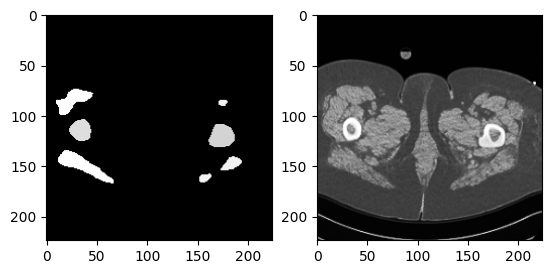

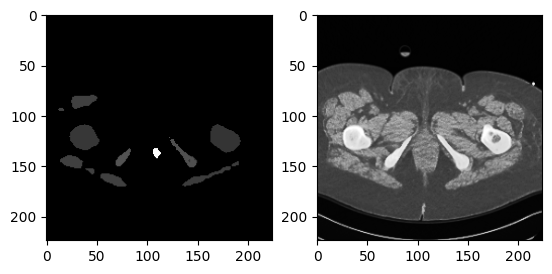

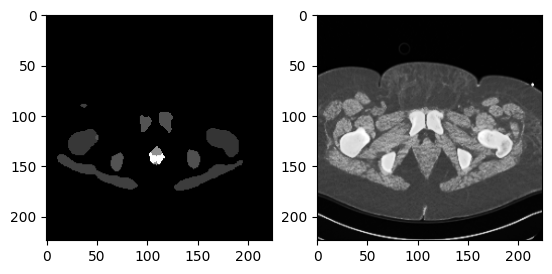

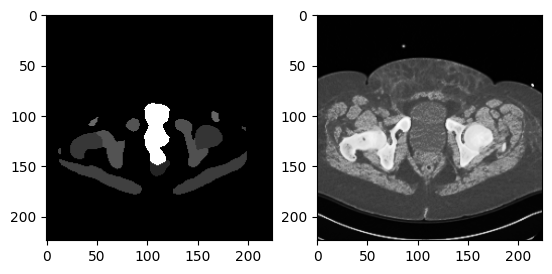

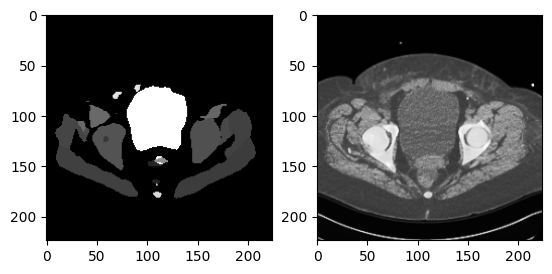

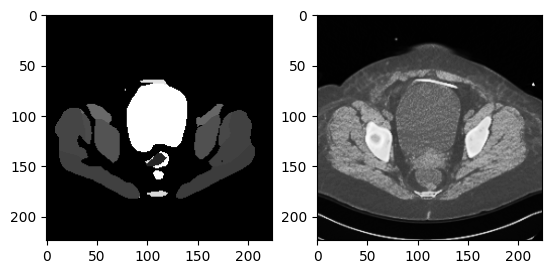

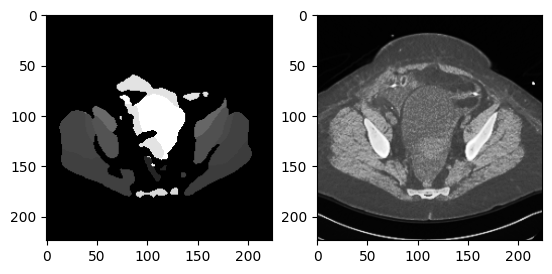

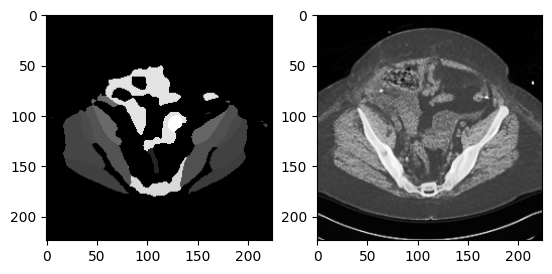

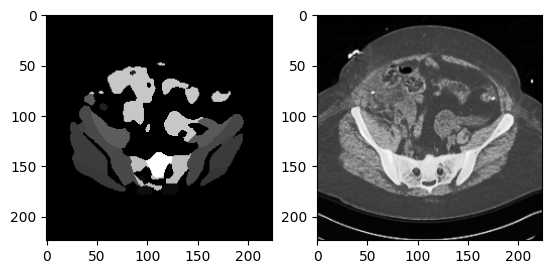

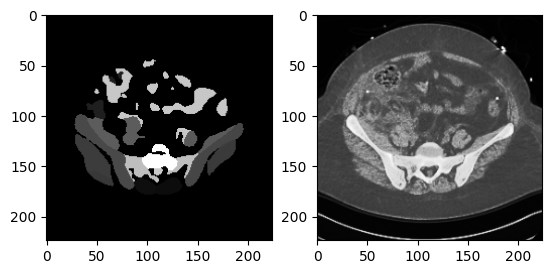

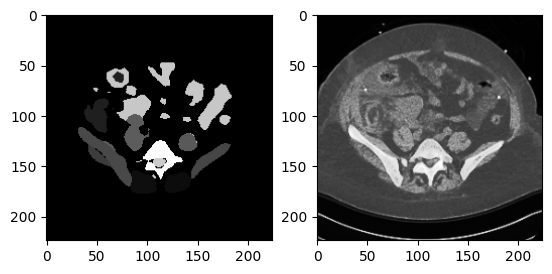

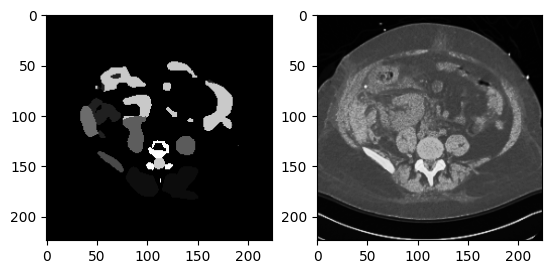

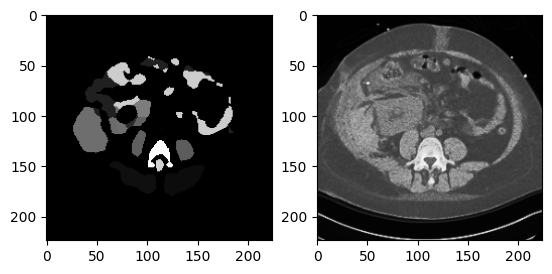

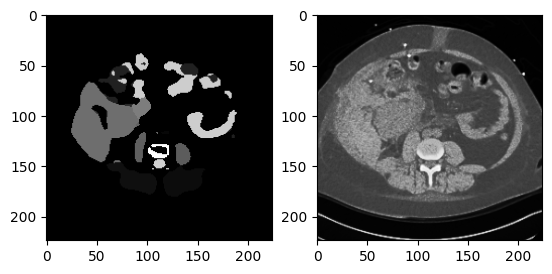

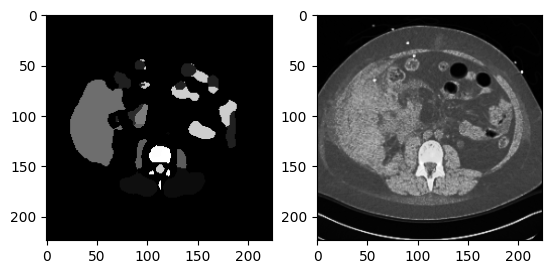

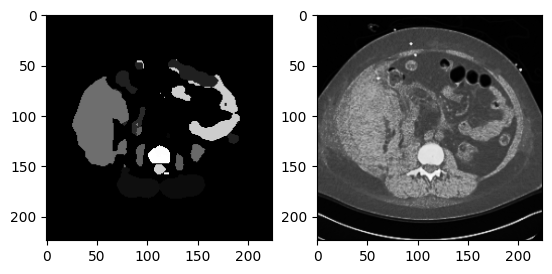

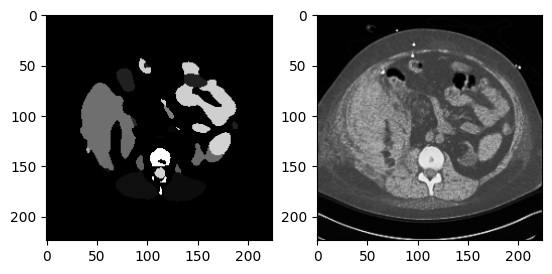

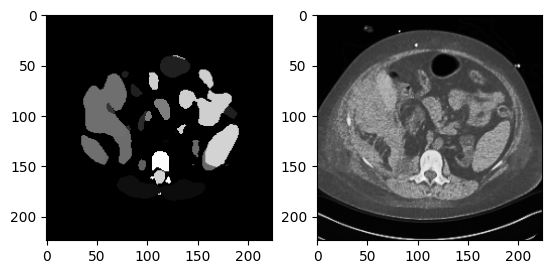

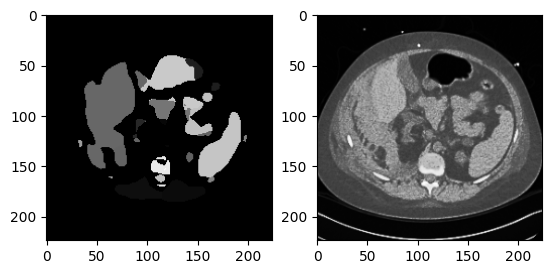

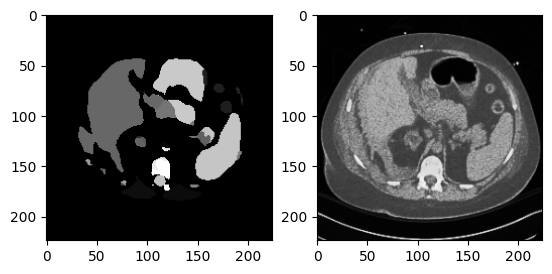

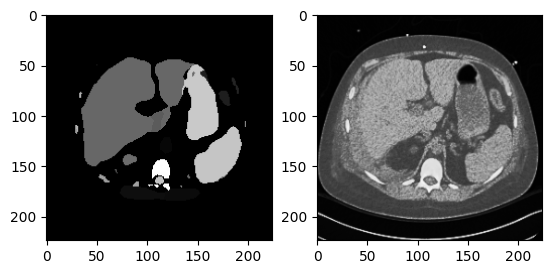

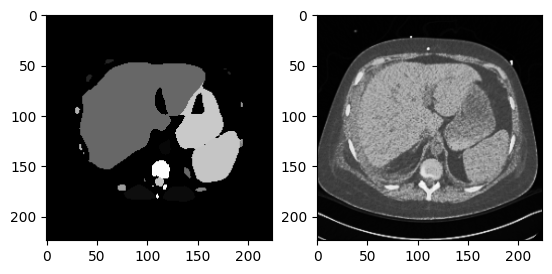

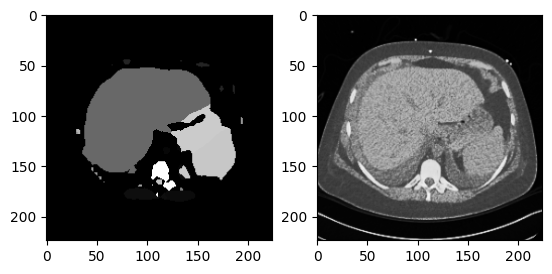

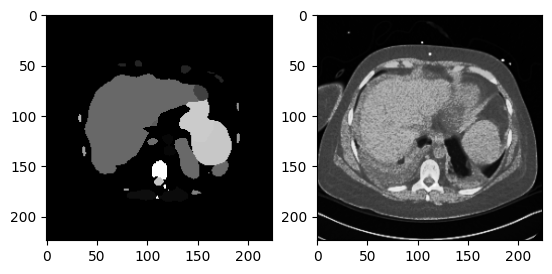

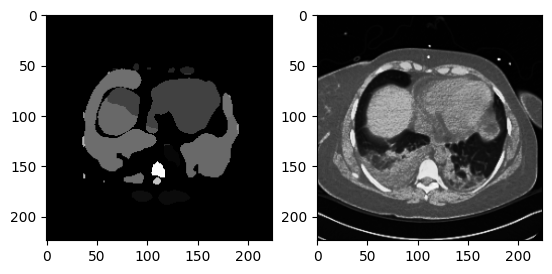

In [40]:
from skp.toolbox.functions import plot_3d_image_side_by_side

plot_3d_image_side_by_side(p.cpu().numpy(), x.cpu().numpy()[:, 0], axis=0, num_images=24)

In [ ]:
torch.unique(chunk)

In [ ]:
tmp_p = model({"seg": {"x": chunk.cuda()}})["seg"]["logits"].sigmoid()
tmp_p = torch.cat([1 - tmp_p.amax(1, keepdim=True), tmp_p], dim=1)
tmp_p = tmp_p.argmax(1)
plot_3d_image(tmp_p.cpu().numpy(), axis=0, num_images=24)

In [ ]:
plot_3d_image(chunk[:, 0].numpy(), axis=0, num_images=24)

In [ ]:
from skp.toolbox.functions import plot_3d_image_side_by_side

plot_3d_image_side_by_side(y.cpu().numpy(), x[:, 0].cpu().numpy(), axis=0, num_images=20)

In [ ]:
dice_scores

In [ ]:
dice_scores

In [ ]:
for bs in range(0, x.shape[0], cfg.num_slices):
    print(bs)
    print(x[bs:bs+cfg.num_slices].shape)